# Uwezo — Bank Statement Layout Detection

This notebook builds and evaluates a **layout detector** for bank statements as part of Uwezo’s document-verification pipeline. It covers:

- **Data loading & conversion (CreateML → YOLO, “You Only Look Once”)**  
  Convert Apple’s **CreateML** annotation format into **YOLO** format (images + text labels + `dataset.yaml`).

- **Exploratory Data Analysis (EDA)**  
  Inspect class balance, visualize labeled samples, and look for labeling gaps.

- **Training & validation with YOLOv8**  
  Train a modern object detector (**YOLOv8**) to find tables and key text regions; evaluate with standard metrics.

- **Quick inference and model export (ONNX, “Open Neural Network eXchange”)**  
  Run predictions on sample pages and export the trained model to **ONNX** for easy deployment.

- **Pointers for downstream OCR (“Optical Character Recognition”) + IE (“Information Extraction”) with LayoutLMv3**  
  After detection, run **OCR** to read text and use **LayoutLMv3** (a layout-aware transformer model) to extract fields like account holder name, bank name, opening balance, total credit, total debit, and closing balance. Apply rule checks such as  
  `opening balance + total credit − total debit ≈ closing balance`.

---
## Why this matters (KYC context)
Bank statements help verify:
- **Identity & ownership** (name, bank, account number),
- **Financial behavior** (credits/debits),
- **Consistency** (opening + credits − debits ≈ closing).

Automating layout detection reduces manual workload and feeds a **human-in-the-loop** review loop for continuous improvement.


## Mini-glossary
- **YOLO (You Only Look Once):** A family of fast object-detection models (we use **YOLOv8**).  
- **CreateML:** Apple’s dataset/annotation format often used by Xcode/Apple tooling.  
- **EDA (Exploratory Data Analysis):** Quick checks and visualizations to understand your dataset.  
- **OCR (Optical Character Recognition):** Converting images of text into machine-readable text.  
- **IE (Information Extraction):** Pulling structured fields from text (e.g., totals, names, dates).  
- **LayoutLMv3:** A transformer model that uses text + layout (positions of words) for document understanding.  
- **ONNX (Open Neural Network eXchange):** A portable model format for inference across runtimes.  

---



## 0) Environment setup

In [1]:
%pip install -r "/Volumes/Peach/uwezo_capstone_project/uwezo_project/requirements.txt"


Note: you may need to restart the kernel to use updated packages.


In [ ]:
%pip install ultralytics

In [ ]:
%pip install paddleocr

## 1) Import

In [1]:
# Standard & paths
from pathlib import Path
import os, sys, json, shutil, random, re
from typing import List, Dict, Tuple

# Data & visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Computer Vision and Deep Learning
import torch
from ultralytics import YOLO
import cv2
from PIL import Image

# Utility helpers
import yaml
from collections import Counter, defaultdict
from tqdm import tqdm
from IPython.display import display, Image as IPyImage

print("Torch:", getattr(torch, "__version__", None))
print("MPS available:", hasattr(torch.backends, "mps") and torch.backends.mps.is_available())
print("OpenCV:", cv2.__version__)


Torch: 2.9.0
MPS available: True
OpenCV: 4.10.0


## 2) Configurations and Paths

In [2]:
# Dataset directories
REPO_ROOT = Path.cwd()
DATA_DIR       = REPO_ROOT / "uwezo_project" / "data"
CREATEML_DIR   = DATA_DIR / "bank_statements.v1i.createml"
TRAIN_IMG_DIR  = CREATEML_DIR / "train"
VAL_IMG_DIR    = CREATEML_DIR / "valid"

# CreateML annotations (one per split)
CREATEML_JSONS = {
    "train": TRAIN_IMG_DIR / "_annotations.createml.json",
    "val":   VAL_IMG_DIR   / "_annotations.createml.json", 
}

# Image path
IMG_SEARCH_ROOT = CREATEML_DIR

# YOLO output dataset root
YOLO_ROOT = REPO_ROOT / "yolo"
for split in ["train","val","test"]:
    (YOLO_ROOT / "images" / split).mkdir(parents=True, exist_ok=True)
    (YOLO_ROOT / "labels" / split).mkdir(parents=True, exist_ok=True)

print("REPO_ROOT:", REPO_ROOT)
print("DATA_DIR:", DATA_DIR)
print("CREATEML_DIR:", CREATEML_DIR)
print("Expecting JSONs:", CREATEML_JSONS)
print("YOLO_ROOT:", YOLO_ROOT)


REPO_ROOT: /Volumes/Peach/uwezo_capstone_project/uwezo_project/notebooks
DATA_DIR: /Volumes/Peach/uwezo_capstone_project/uwezo_project/notebooks/uwezo_project/data
CREATEML_DIR: /Volumes/Peach/uwezo_capstone_project/uwezo_project/notebooks/uwezo_project/data/bank_statements.v1i.createml
Expecting JSONs: {'train': PosixPath('/Volumes/Peach/uwezo_capstone_project/uwezo_project/notebooks/uwezo_project/data/bank_statements.v1i.createml/train/_annotations.createml.json'), 'val': PosixPath('/Volumes/Peach/uwezo_capstone_project/uwezo_project/notebooks/uwezo_project/data/bank_statements.v1i.createml/valid/_annotations.createml.json')}
YOLO_ROOT: /Volumes/Peach/uwezo_capstone_project/uwezo_project/notebooks/yolo


## 3) Convert CreateML → YOLO


In [3]:
NB_DIR = Path.cwd()

def find_dataset_root() -> Path | None:
    # Try common layouts relative to the notebook
    candidates = []
    for base in [NB_DIR, *NB_DIR.parents]:
        for rel in [
            Path("uwezo_project/data/bank_statements.v1i.createml"),
            Path("data/bank_statements.v1i.createml"),
            Path("bank_statements.v1i.createml"),
        ]:
            p = (base / rel).resolve()
            if p.exists():
                candidates.append(p)
    if candidates:
        return candidates[0]
    # Fallback: search upward for the folder name
    for base in [NB_DIR, *NB_DIR.parents]:
        hits = list(base.rglob("bank_statements.v1i.createml"))
        if hits:
            return hits[0].resolve()
    return None

def find_split_json(split_dir: Path):
    # Try a few common CreateML/COCO filenames
    for name in ["_annotations.createml.json", "_annotations.coco.json", "annotations.json"]:
        p = split_dir / name
        if p.exists():
            return p
    return None

DATASET_ROOT = find_dataset_root()
if not DATASET_ROOT:
    raise FileNotFoundError(
        "Couldn't find 'bank_statements.v1i.createml' near this notebook. "
        "Move the notebook to your repo root or set DATASET_ROOT manually."
    )

TRAIN_IMG_DIR = DATASET_ROOT / "train"
VAL_IMG_DIR   = DATASET_ROOT / "valid"   # CreateML uses 'valid'

TRAIN_JSON = find_split_json(TRAIN_IMG_DIR)
VAL_JSON   = find_split_json(VAL_IMG_DIR)

print("DATASET_ROOT:", DATASET_ROOT)
print("TRAIN_IMG_DIR:", TRAIN_IMG_DIR, "exists:", TRAIN_IMG_DIR.exists())
print("VAL_IMG_DIR:",   VAL_IMG_DIR,   "exists:", VAL_IMG_DIR.exists())
print("TRAIN JSON:", TRAIN_JSON)
print("VAL JSON:",   VAL_JSON)

if not TRAIN_JSON or not VAL_JSON:
    missing = []
    if not TRAIN_JSON: missing.append(str(TRAIN_IMG_DIR / "_annotations.createml.json"))
    if not VAL_JSON:   missing.append(str(VAL_IMG_DIR   / "_annotations.createml.json"))
    raise FileNotFoundError(
        "Missing expected CreateML JSON(s):\n  - " + "\n  - ".join(missing)
        + "\nIf your files are named differently, update `find_split_json()`."
    )

# Use these for the converter:
CREATEML_JSONS = {"train": TRAIN_JSON, "val": VAL_JSON}
IMG_SEARCH_ROOT = DATASET_ROOT

# Put YOLO outputs at the repo root
PROJECT_ROOT = DATASET_ROOT.parent.parent if DATASET_ROOT.name == "bank_statements.v1i.createml" else NB_DIR
YOLO_ROOT = PROJECT_ROOT / "yolo"
for split in ["train", "val"]:  # no test by default
    (YOLO_ROOT / "images" / split).mkdir(parents=True, exist_ok=True)
    (YOLO_ROOT / "labels" / split).mkdir(parents=True, exist_ok=True)

print("YOLO_ROOT:", YOLO_ROOT)


DATASET_ROOT: /Volumes/Peach/uwezo_capstone_project/uwezo_project/data/bank_statements.v1i.createml
TRAIN_IMG_DIR: /Volumes/Peach/uwezo_capstone_project/uwezo_project/data/bank_statements.v1i.createml/train exists: True
VAL_IMG_DIR: /Volumes/Peach/uwezo_capstone_project/uwezo_project/data/bank_statements.v1i.createml/valid exists: True
TRAIN JSON: /Volumes/Peach/uwezo_capstone_project/uwezo_project/data/bank_statements.v1i.createml/train/_annotations.createml.json
VAL JSON: /Volumes/Peach/uwezo_capstone_project/uwezo_project/data/bank_statements.v1i.createml/valid/_annotations.createml.json
YOLO_ROOT: /Volumes/Peach/uwezo_capstone_project/uwezo_project/yolo


In [4]:
# classes to keep
MUST_KEEP = [
    "table_transactions_data",
    "table_transactions_header",
    "account_holder_name",
    "bank_name",
    "account_number",
    "statement_period",
]

# optionally keep these (set to True to include)
INCLUDE_OPTIONAL = True
OPTIONAL = ["opening_balance", "currency", "doc_type"] if INCLUDE_OPTIONAL else []

CLASSES = MUST_KEEP + OPTIONAL
cls2id = {c: i for i, c in enumerate(CLASSES)}
print("Keeping classes:", CLASSES)

# helpers
def find_image_on_disk(filename: str, root: Path) -> Path | None:
    m = list(root.rglob(filename)); return m[0] if m else None

def clamp(v, lo, hi): return max(lo, min(hi, v))
def to_center_norm(cx, cy, w, h, W, H): return cx/W, cy/H, w/W, h/H
def to_tl_norm(x, y, w, h, W, H): return to_center_norm(x+w/2, y+h/2, w, h, W, H)

def write_label(p: Path, cls_id: int, box):
    cx, cy, w, h = box
    if not (0 < w <= 1 and 0 < h <= 1): return
    cx, cy = clamp(cx,0,1), clamp(cy,0,1)
    p.parent.mkdir(parents=True, exist_ok=True)
    with open(p,"a") as f:
        f.write(f"{cls_id} {cx:.6f} {cy:.6f} {w:.6f} {h:.6f}\n")

# convert (filters to CLASSES)
converted, skipped, missing = Counter(), Counter(), []
for split, json_path in CREATEML_JSONS.items():
    yolo_split = "val" if split == "val" else split
    items = json.loads(Path(json_path).read_text())
    for row in items:
        fname = row["image"]
        src = find_image_on_disk(fname, IMG_SEARCH_ROOT)
        if not src: missing.append((split,fname)); continue
        with Image.open(src) as im: W, H = im.size

        dst_img = YOLO_ROOT / "images" / yolo_split / fname
        dst_lbl = YOLO_ROOT / "labels" / yolo_split / (Path(fname).stem + ".txt")
        if not dst_img.exists():
            dst_img.parent.mkdir(parents=True, exist_ok=True)
            shutil.copy2(src, dst_img)
        if dst_lbl.exists(): dst_lbl.unlink()

        wrote = False
        for ann in row.get("annotations", []):
            label = ann["label"]
            if label not in cls2id: 
                skipped["dropped_label"] += 1
                continue
            c = ann.get("coordinates", {})
            if not all(k in c for k in ("x","y","width","height")):
                skipped["bad_coords"] += 1; 
                continue
            x,y,w,h = float(c["x"]),float(c["y"]),float(c["width"]),float(c["height"])
            bx = to_center_norm(x,y,w,h,W,H)
            if not (0 < bx[2] <= 1 and 0 < bx[3] <= 1):   # fallback if x,y were TL
                bx = to_tl_norm(x,y,w,h,W,H)
            if bx[2] <= 0 or bx[3] <= 0:
                skipped["nonpositive_wh"] += 1; 
                continue
            write_label(dst_lbl, cls2id[label], bx); wrote = True

        if wrote: converted[yolo_split] += 1
        else:     skipped["no_valid_boxes"] += 1

print("Converted:", dict(converted))
if missing: print(f"Missing images: {len(missing)} (first 10):", missing[:10])
print("Skipped (reasons):", dict(skipped))

# write dataset.yaml for the kept classes
(YOLO_ROOT / "images" / "train").mkdir(parents=True, exist_ok=True)
(YOLO_ROOT / "labels" / "train").mkdir(parents=True, exist_ok=True)
(YOLO_ROOT / "images" / "val").mkdir(parents=True, exist_ok=True)
(YOLO_ROOT / "labels" / "val").mkdir(parents=True, exist_ok=True)

dataset_yaml = YOLO_ROOT / "dataset.yaml"
dataset_yaml.write_text(
    f"path: {YOLO_ROOT.as_posix()}\n"
    f"train: images/train\n"
    f"val: images/val\n\n"
    "names:\n" + "".join([f"  {i}: {n}\n" for i,n in enumerate(CLASSES)])
)
print("Wrote:", dataset_yaml)


Keeping classes: ['table_transactions_data', 'table_transactions_header', 'account_holder_name', 'bank_name', 'account_number', 'statement_period', 'opening_balance', 'currency', 'doc_type']
Converted: {'train': 380, 'val': 47}
Skipped (reasons): {'dropped_label': 617}
Wrote: /Volumes/Peach/uwezo_capstone_project/uwezo_project/yolo/dataset.yaml


## 3) Data Exploration
Compute class counts and show a few samples.

A) Summary: images, classes, counts

,train,val
table_transactions_data,374,47
statement_period,220,25
doc_type,188,25
account_holder_name,174,18
bank_name,164,22
table_transactions_header,162,22
account_number,154,19
currency,126,16
opening_balance,46,4


Images — train: 380
Images — val: 47


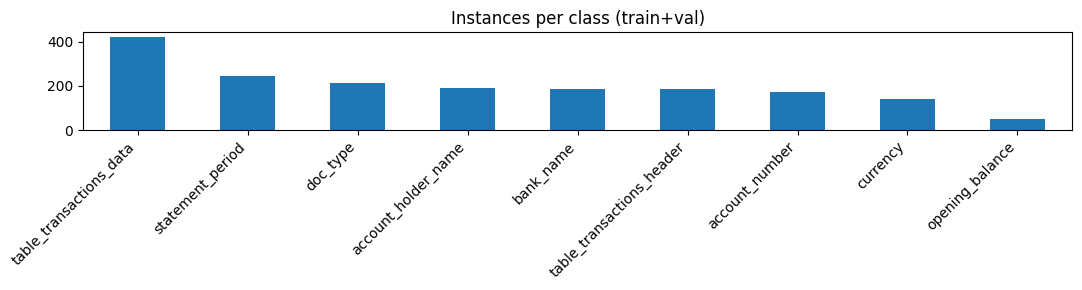

In [5]:
YOLO_IMG_TRAIN = YOLO_ROOT / "images" / "train"
YOLO_IMG_VAL   = YOLO_ROOT / "images" / "val"
YOLO_LBL_TRAIN = YOLO_ROOT / "labels" / "train"
YOLO_LBL_VAL   = YOLO_ROOT / "labels" / "val"

def parse_lbl(p: Path):
    ids=[]
    if p.exists():
        for line in open(p):
            parts = line.strip().split()
            if len(parts)==5:
                ids.append(int(parts[0]))
    return ids

def count_split(img_dir: Path, lbl_dir: Path, classes: list[str]):
    c=Counter()
    imgs = list(img_dir.rglob("*.jpg"))+list(img_dir.rglob("*.png"))+list(img_dir.rglob("*.jpeg"))
    for im in imgs:
        rel = im.relative_to(img_dir)
        lbl = lbl_dir / rel.with_suffix(".txt")
        c.update(parse_lbl(lbl))
    return {classes[k]:v for k,v in c.items()}

train_counts = count_split(YOLO_IMG_TRAIN, YOLO_LBL_TRAIN, CLASSES)
val_counts   = count_split(YOLO_IMG_VAL,   YOLO_LBL_VAL,   CLASSES)

df_counts = pd.DataFrame([train_counts, val_counts], index=["train","val"]).fillna(0).astype(int).T
display(df_counts.sort_values("train", ascending=False))

print("Images — train:", len(list(YOLO_IMG_TRAIN.rglob('*.jpg')))+len(list(YOLO_IMG_TRAIN.rglob('*.png'))))
print("Images — val:",   len(list(YOLO_IMG_VAL.rglob('*.jpg')))+len(list(YOLO_IMG_VAL.rglob('*.png'))))

ax = df_counts.sum(axis=1).sort_values(ascending=False).plot(kind="bar", figsize=(11,3), title="Instances per class (train+val)")
plt.xticks(rotation=45, ha='right'); plt.tight_layout(); plt.show()


B) Class imbalance flags (rare classes)

In [6]:
MIN_PER_CLASS = 30  # tweak threshold
rare = df_counts.sum(axis=1)[df_counts.sum(axis=1) < MIN_PER_CLASS].sort_values()
display(rare.to_frame("total_instances"))

print("Rare classes (<", MIN_PER_CLASS, "instances):", list(rare.index))


,total_instances


Rare classes (< 30 instances): []


C) Box size & aspect ratio distributions (sanity for detector anchors)

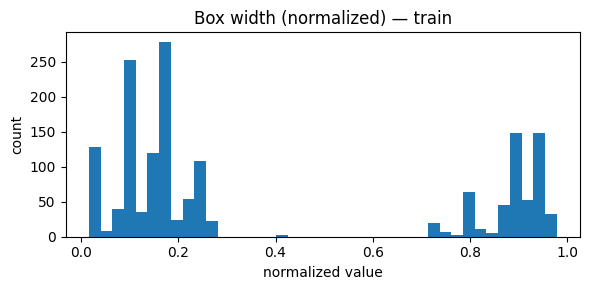

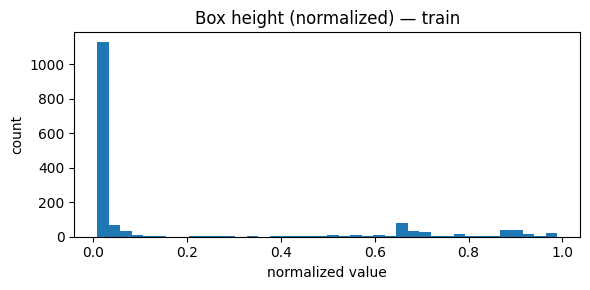

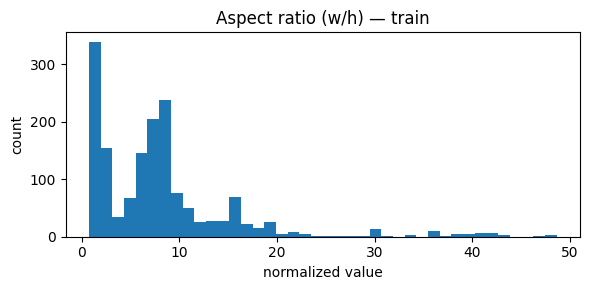

In [7]:
def collect_box_stats(img_dir: Path, lbl_dir: Path):
    ws, hs, ars = [], [], []
    imgs = list(img_dir.rglob("*.jpg"))+list(img_dir.rglob("*.png"))+list(img_dir.rglob("*.jpeg"))
    for im_path in imgs:
        rel = im_path.relative_to(img_dir)
        lbl = lbl_dir / rel.with_suffix(".txt")
        if not lbl.exists(): continue
        with Image.open(im_path) as im:
            W,H = im.size
        for line in open(lbl):
            parts = line.strip().split()
            if len(parts)!=5: continue
            _, cx, cy, w, h = parts
            w, h = float(w), float(h)
            ws.append(w); hs.append(h)
            if h>0: ars.append(w/h)
    return np.array(ws), np.array(hs), np.array(ars)

ws_tr, hs_tr, ars_tr = collect_box_stats(YOLO_IMG_TRAIN, YOLO_LBL_TRAIN)
ws_va, hs_va, ars_va = collect_box_stats(YOLO_IMG_VAL,   YOLO_LBL_VAL)

def hist1(data, title):
    if data.size==0: 
        print(f"No data for {title}"); 
        return
    plt.figure(figsize=(6,3)); plt.hist(data, bins=40)
    plt.title(title); plt.xlabel("normalized value"); plt.ylabel("count"); plt.tight_layout(); plt.show()

hist1(ws_tr, "Box width (normalized) — train")
hist1(hs_tr, "Box height (normalized) — train")
hist1(ars_tr, "Aspect ratio (w/h) — train")


D) Co-occurrence heatmap (which classes appear together)

,table_transactions_data,table_transactions_header,account_holder_name,bank_name,account_number,statement_period,opening_balance,currency,doc_type
table_transactions_data,374,162,172,160,150,216,42,122,184
table_transactions_header,162,162,70,58,34,114,42,20,68
account_holder_name,172,70,174,132,126,174,44,116,156
bank_name,160,58,132,164,140,164,10,122,140
account_number,150,34,126,140,154,140,10,110,148
statement_period,216,114,174,164,140,220,44,124,174
opening_balance,42,42,44,10,10,44,46,4,40
currency,122,20,116,122,110,124,4,124,112
doc_type,184,68,156,140,148,174,40,112,188


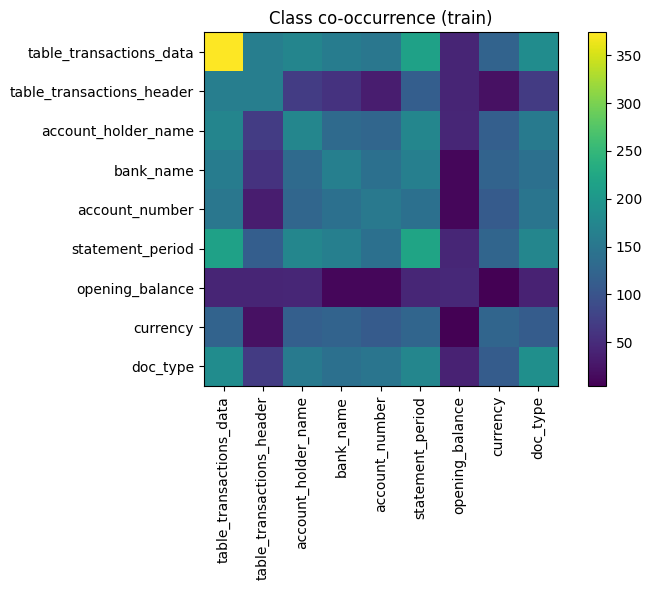

In [8]:
def image_class_vector(img_path: Path, img_root: Path, lbl_root: Path, n_classes: int):
    rel = img_path.relative_to(img_root)
    lbl = lbl_root / rel.with_suffix(".txt")
    v = np.zeros(n_classes, dtype=int)
    if lbl.exists():
        for line in open(lbl):
            parts=line.strip().split()
            if len(parts)==5:
                cid=int(parts[0]); 
                if 0<=cid<n_classes: v[cid]=1
    return v

def cooccurrence(img_root: Path, lbl_root: Path, classes: list[str]):
    imgs = list(img_root.rglob("*.jpg"))+list(img_root.rglob("*.png"))+list(img_root.rglob("*.jpeg"))
    if not imgs: return None
    M = np.zeros((len(classes), len(classes)), dtype=int)
    for im in imgs:
        v = image_class_vector(im, img_root, lbl_root, len(classes))
        M += np.outer(v, v)
    return M

M = cooccurrence(YOLO_IMG_TRAIN, YOLO_LBL_TRAIN, CLASSES)
if M is not None:
    dfM = pd.DataFrame(M, index=CLASSES, columns=CLASSES)
    display(dfM)
    plt.figure(figsize=(8,6))
    plt.imshow(dfM, interpolation='nearest')
    plt.title("Class co-occurrence (train)")
    plt.xticks(range(len(CLASSES)), CLASSES, rotation=90)
    plt.yticks(range(len(CLASSES)), CLASSES)
    plt.colorbar(); plt.tight_layout(); plt.show()
else:
    print("No images found for co-occurrence.")


E) Quick visual check (draw a few boxes)

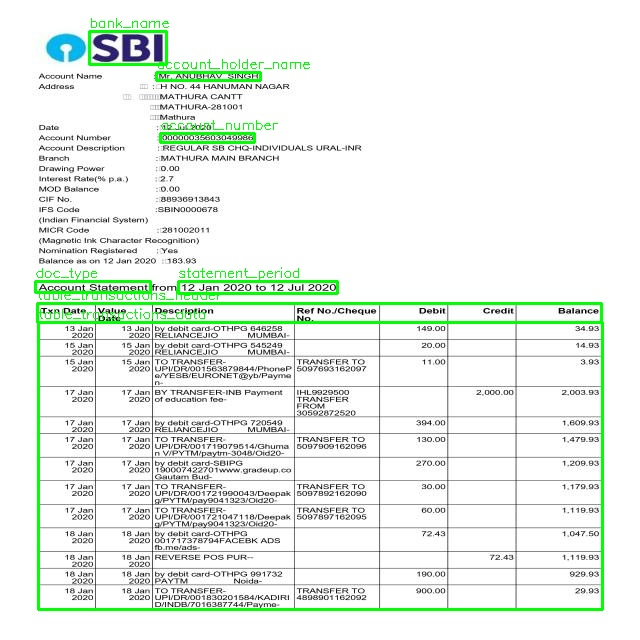

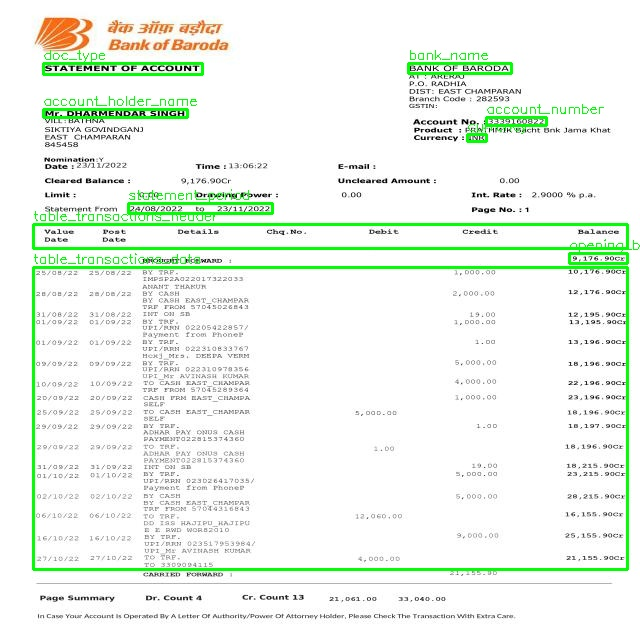

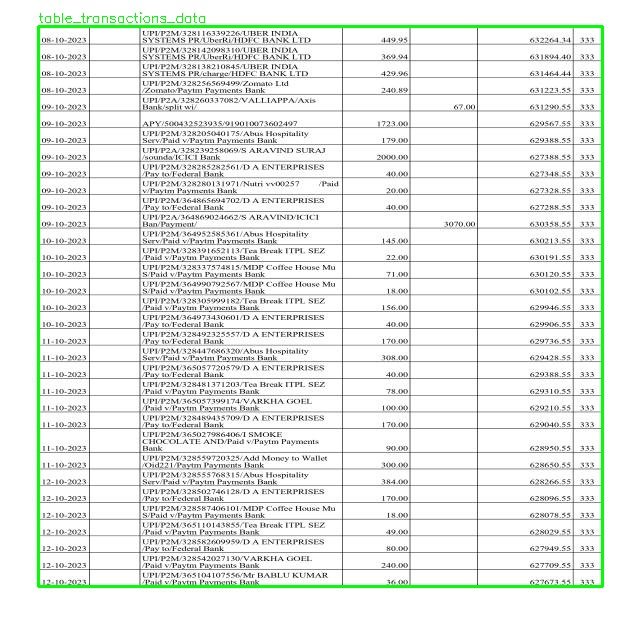

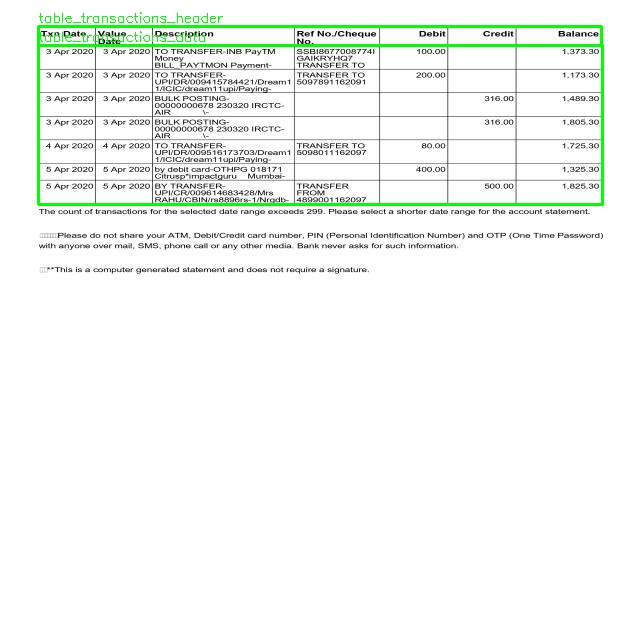

In [9]:
def draw_boxes(img_path: Path, lbl_path: Path, classes: list[str]):
    im = cv2.imread(str(img_path))
    if im is None: return None
    H, W = im.shape[:2]
    if lbl_path.exists():
        for ln in open(lbl_path):
            ps = ln.strip().split()
            if len(ps)!=5: continue
            cid = int(ps[0]); cx,cy,w,h = map(float, ps[1:])
            x1 = int((cx - w/2)*W); y1 = int((cy - h/2)*H)
            x2 = int((cx + w/2)*W); y2 = int((cy + h/2)*H)
            cv2.rectangle(im, (x1,y1), (x2,y2), (0,255,0), 2)
            name = classes[cid] if 0<=cid<len(classes) else str(cid)
            cv2.putText(im, name, (x1, max(12,y1-4)), cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0,255,0), 1)
    tmp = YOLO_ROOT / f"_viz_{img_path.stem}.jpg"
    cv2.imwrite(str(tmp), im)
    return tmp

val_imgs = list(YOLO_IMG_VAL.rglob("*.jpg"))+list(YOLO_IMG_VAL.rglob("*.png"))
random.shuffle(val_imgs)
for p in val_imgs[:4]:
    rel = p.relative_to(YOLO_IMG_VAL)
    lbl = YOLO_LBL_VAL / rel.with_suffix(".txt")
    out = draw_boxes(p, lbl, CLASSES)
    if out: display(IPyImage(filename=str(out)))


## 4) Preprocessing (optional class remaps / filtering)
Use this to drop rare classes or merge labels before training.

In [ ]:

# Example: drop extremely rare classes (like pan_number if only a handful exist) to stabilize training
RARE_CLASSES = ["pan_number"]  # change as needed

def build_class_remap(classes, drop_list):
    keep = [c for c in classes if c not in drop_list]
    idx_map = {i: keep.index(c) for i, c in enumerate(classes) if c in keep}
    return keep, idx_map

NEW_CLASSES, IDX_MAP = build_class_remap(CLASSES, RARE_CLASSES)
print("New classes:", NEW_CLASSES)
print("Index map (old->new):", IDX_MAP)

# Write a remapped dataset (optional). For large sets, consider doing this offline once.
REMAPPED_ROOT = WORK_DIR / "remapped"
def remap_yolo_dataset(src_img_dir, src_lbl_dir, dst_img_dir, dst_lbl_dir):
    dst_img_dir.mkdir(parents=True, exist_ok=True)
    dst_lbl_dir.mkdir(parents=True, exist_ok=True)
    imgs = list(src_img_dir.rglob("*.jpg")) + list(src_img_dir.rglob("*.png"))
    for img in imgs:
        rel = img.relative_to(src_img_dir)
        lbl = src_lbl_dir / rel.with_suffix(".txt")
        # copy image
        (dst_img_dir / rel.parent).mkdir(parents=True, exist_ok=True)
        (dst_lbl_dir / rel.parent).mkdir(parents=True, exist_ok=True)
        shutil.copy2(img, dst_img_dir / rel)
        # remap labels
        if lbl.exists():
            out_lines = []
            for line in open(lbl):
                parts = line.strip().split()
                if len(parts) != 5: continue
                old_id = int(parts[0])
                if old_id in IDX_MAP:
                    new_id = IDX_MAP[old_id]
                    out_lines.append(" ".join([str(new_id)] + parts[1:]))
            with open(dst_lbl_dir / rel.with_suffix(".txt"), "w") as f:
                f.write("\n".join(out_lines))

# Example call (commented by default)
# remap_yolo_dataset(train_img_dir, LABELS_DIR/"train", REMAPPED_ROOT/"images/train", REMAPPED_ROOT/"labels/train")
# remap_yolo_dataset(val_img_dir,   LABELS_DIR/"val",   REMAPPED_ROOT/"images/val",   REMAPPED_ROOT/"labels/val")
# write_dataset_yaml(REMAPPED_ROOT/"images/train", REMAPPED_ROOT/"images/val", None, NEW_CLASSES)


## 5) Train & Finetune YOLO (Ultralytics)
Trains a detector on the Roboflow dataset to localize statement regions (tables, names, balances, etc.).

In [ ]:

# Ultralytics imports
try:
    from ultralytics import YOLO
except Exception as e:
    print("Ultralytics not available. Install with: pip install ultralytics")
    raise

MODEL_NAME = "yolov8n.pt"  # start small; can switch to yolov8s.pt / yolov8m.pt later
RUN_NAME = "uwezo_yolov8n_bankstatements"

# Train
model = YOLO(MODEL_NAME)
results = model.train(
    data=str(DATASET_YAML),
    epochs=50,
    imgsz=1024,
    batch=8,
    name=RUN_NAME,
    optimizer="auto",
    lr0=0.003,
    weight_decay=0.0005,
    cos_lr=True,
    patience=20,
    verbose=True
)

# Evaluate on val
metrics = model.val(data=str(DATASET_YAML), imgsz=1024, batch=8)
print(metrics)


## 6) Inference & Export

In [ ]:

# Export the fine-tuned model
export_path = model.export(format="onnx")  # you can also export to torchscript, openvino, etc.
print("Exported model:", export_path)

# Quick inference demo (uncomment and set a sample image path)
# sample_img = str(next((val_img_dir).rglob("*.jpg")))
# preds = model.predict(sample_img, imgsz=1024, conf=0.25, iou=0.45)
# preds[0].show()


## 7) (Optional) Hooks for OCR & IE
After detection, route `table` and `text` regions to OCR and then to an IE model (e.g., LayoutLMv3).

In [ ]:

# Pseudocode for routing and OCR (fill in later once detector is trained & paths available)
# from paddleocr import PaddleOCR
# ocr = PaddleOCR(lang='en', show_log=False)

# def crop_and_ocr(image_path, boxes, cls_names):
#     # boxes: list of [x1,y1,x2,y2]
#     import cv2, numpy as np
#     img = cv2.imread(image_path)
#     results = []
#     for box, cls in zip(boxes, cls_names):
#         x1,y1,x2,y2 = map(int, box)
#         crop = img[y1:y2, x1:x2]
#         if cls in ("table_transactions_header", "table_transactions_data", "account_holder_name", "bank_name", "opening_balance"):
#             # run OCR
#             txt = ocr.ocr(crop, cls=False)
#             results.append((cls, txt))
#     return results
